In [14]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import itertools
import os
import re
import pickle
from string import punctuation 
import nltk
import nltk.data
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [2]:
df = pd.read_pickle('../data/raw/emotions_training.pkl')

In [3]:
df=df.reset_index()

In [4]:
#Defining class for each emotion
df['labels'] = df['emotions'].factorize()[0]
df.head()


,index,text,emotions,labels
0,27383,i feel awful about it too because it s my job ...,sadness,0
1,110083,im alone i feel awful,sadness,0
2,140764,ive probably mentioned this before but i reall...,joy,1
3,100071,i was feeling a little low few days back,sadness,0
4,2837,i beleive that i am much more sensitive to oth...,love,2


In [11]:
def text_cleaning(text):
   
    text=re.sub("\(.*?\)","",text)

    text = re.sub(r"[^A-Za-z]", " ", str(text))
    
     #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.split()
    text = [w for w in text if not w in stopwords]
    text = " ".join(text)
        
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    text=text.lower()
    
    return text 

In [15]:
df['cleaned_text'] = df['text'].apply(lambda x: text_cleaning(x))
df = df[df['cleaned_text'].map(len) > 0]

In [16]:
df.shape

(416793, 5)

In [17]:
uniquevalues = pd.unique(df[['emotions']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['emotion'])


In [18]:
df_unique

,emotion
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise


In [37]:
#importing libraries for models and nlp tasks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_class_weight

### TF-IDF Vectorization for models

In [20]:
tfidf_vectorizer = TfidfVectorizer()

In [21]:
y =df['labels']

In [22]:
#Train test split of the data
Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'], y, test_size=0.3,random_state=1)
Xtrain_tfidf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [23]:
pickle.dump(tfidf_vectorizer, open('../tfidfvectors/tfidf_vect_clean.pkl', 'wb'))

##### Logistic Regression

In [24]:
#Logistic Regression with One vs Rest
lr_ovr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr_ovr.fit(Xtrain_tfidf, ytrain)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [25]:
ypred_lr_ovr=lr_ovr.predict(Xtest_tfidf)

In [26]:
len(ypred_lr_ovr)

125038

In [27]:
tr_acc_lr_ovr = lr_ovr.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_ovr =  accuracy_score(ytest,ypred_lr_ovr) * 100
print(tr_acc_lr_ovr,test_acc_lr_ovr)

91.94392555397508 89.82389353636493


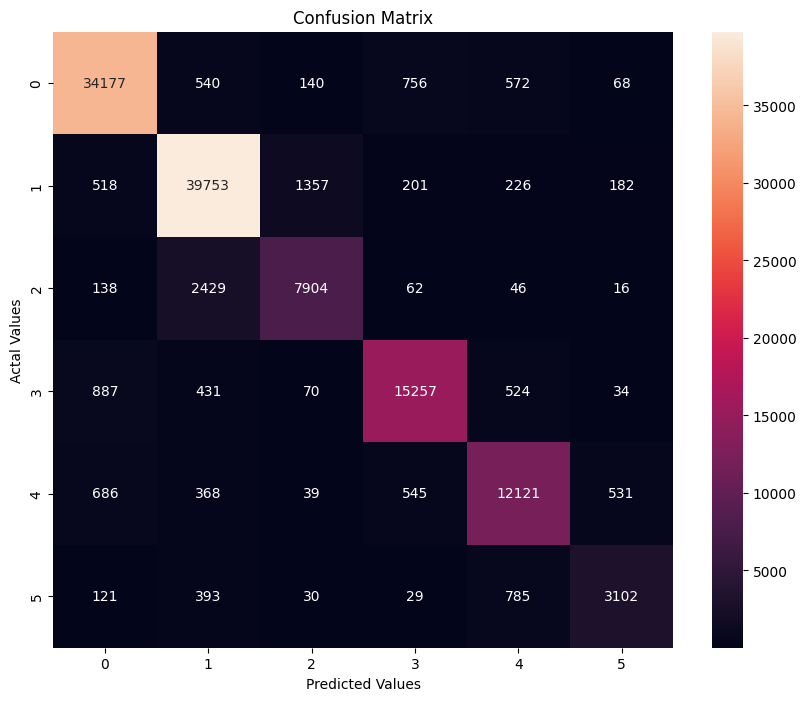

In [28]:
cm = confusion_matrix(ytest, ypred_lr_ovr)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [29]:
print(classification_report(ytest,ypred_lr_ovr, digits=3))

              precision    recall  f1-score   support

           0      0.936     0.943     0.939     36253
           1      0.905     0.941     0.923     42237
           2      0.829     0.746     0.785     10595
           3      0.905     0.887     0.896     17203
           4      0.849     0.848     0.849     14290
           5      0.789     0.696     0.739      4460

    accuracy                          0.898    125038
   macro avg      0.869     0.843     0.855    125038
weighted avg      0.897     0.898     0.897    125038



In [30]:
pickle.dump(lr_ovr, open('../models/lr_ovr_clean.pkl', 'wb'))

In [31]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(Xtrain_tfidf, ytrain)


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [32]:
ypred_lr_mn=lr_mn.predict(Xtest_tfidf)

In [33]:
tr_acc_lr_mn = lr_mn.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

91.69371561755582 90.05422351605112


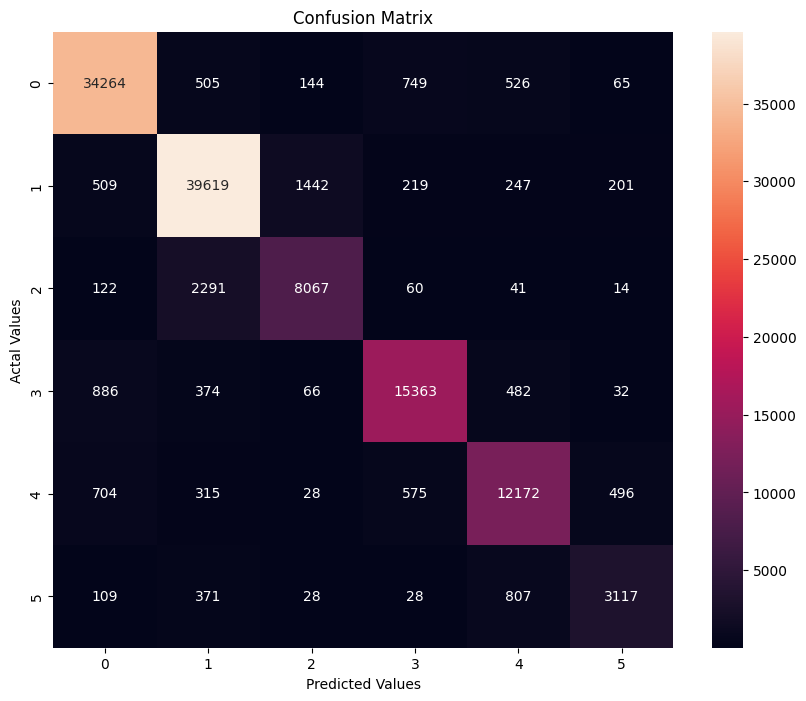

In [34]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [35]:
pickle.dump(lr_mn, open('../models/lr_mn_clean.pkl', 'wb'))

##### Class weights

In [38]:
weighting = compute_class_weight( class_weight ='balanced', classes =np.unique(y),y= y)
class_weights = dict(zip(np.unique(y), weighting))


In [40]:
lr_mn_cw = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weights)
lr_mn_cw.fit(Xtrain_tfidf, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5732280930493551, 1: 0.4924396018828333,
                                 2: 2.0103461249059444, 3: 1.2120797054666643,
                                 4: 1.4560250686453289, 5: 4.639694095645204},
                   multi_class='multinomial')

In [41]:
ypred_lr_mn_cw=lr_mn_cw.predict(Xtest_tfidf)

In [42]:
tr_acc_lr_mn_cw = lr_mn_cw.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn_cw =  accuracy_score(ytest,ypred_lr_mn_cw) * 100
print(tr_acc_lr_mn_cw,test_acc_lr_mn_cw)

90.9235488680571 90.0294310529599


In [44]:
pickle.dump(lr_mn_cw, open('../models/lr_mn_clean_cw.pkl', 'wb'))